In [11]:
import pandas as pd
from scipy import stats
import scipy.stats as ss
from scipy.stats import shapiro
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from scipy.stats import mannwhitneyu

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [12]:
#загрузка данных
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-postnova/Statistics/9 lesson project/hw_bootstrap.csv', sep = ';', decimal=',')
df_origin = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-postnova/Statistics/9 lesson project/hw_bootstrap.csv', sep = ';', decimal=',')

In [13]:
df.tail(10) #посмотрим на данные, с первого взгляда пять последних значений сильно отличаются от всех

,Unnamed: 0,value,experimentVariant
990,991,10.916229,Treatment
991,992,11.160869,Treatment
992,993,8.202518,Treatment
993,994,9.782199,Treatment
994,995,10.484967,Treatment
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment
999,1000,3000.000000,Treatment


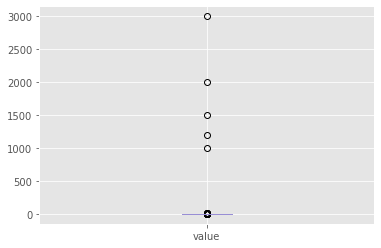

In [14]:
bp = df.value.plot.box() #проверяем на выбросы

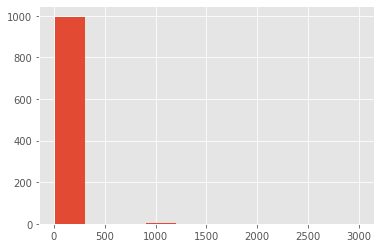

In [15]:
df.value.hist()

При помощи метода quantile получаем соответствующую нижнюю и верхнюю границы, а затем выводим всё, что выходит за их рамки:

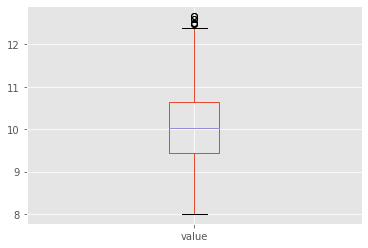

In [16]:
Q1 =  df['value'].quantile(0.01)
Q3 = df['value'].quantile(0.99)
IQR = Q3 - Q1
df_IQR = df[(df['value'] > Q1) & (df['value'] < Q3)]
df_IQR.boxplot(column="value")

In [17]:
df = df_IQR #перезаписать данные в датафрейм без выбросов

Алгоритм проверки статистической гипотезы в обобщенном виде выглядит таким образом:\
1. Формулировка основной (H0) и альтернативной (H1) гипотез
2. Выбор уровня значимости
3. Выбор статистического критерия
4. Определения правила принятия решения
5. Итоговое принятие решения на основе исходной выборки данных

In [19]:
#Проверим выборки нанормальность (после отсева выбросов)

H0: случайная величина распределена нормально \
H1: случайная величина не распределена нормально \
Пусть уровень значимости alpha = 0.05 (как и в 95-ти процентах статистических тестов). \
Определение уровня значимости достойно отдельного поста, так что не будем заострять на нем внимание. Будет использован критерий Шапиро-Уилка.

In [20]:
shapiro(df[df['experimentVariant'] == 'Control']['value'])

ShapiroResult(statistic=0.9937092661857605, pvalue=0.03872174769639969)

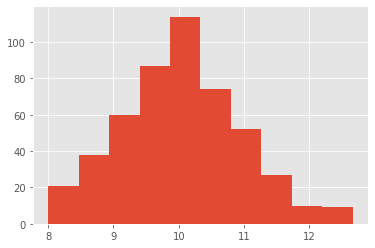

In [21]:
df[df['experimentVariant'] == 'Control']['value'].hist()

In [22]:
shapiro(df[df['experimentVariant'] == 'Treatment']['value'])

ShapiroResult(statistic=0.9934811592102051, pvalue=0.033749185502529144)

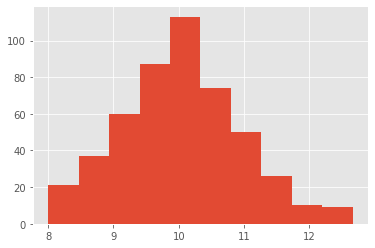

In [23]:
df[df['experimentVariant'] == 'Treatment']['value'].hist()

Основная гипотеза:\
H0: отсутствует статистически значимое различие в значениях Value в тестовой и контрольной группе\
H1: признается статистическая значимость изменения показателя выручки Value в тестовой и контрольной группе\
Пусть уровень значимости alpha = 0.05

Проверить гипотезу можно параметрическим или непараметрическим критерием. 
Самый распространенный параметрический тест — критерий Стьюдента. Для двух независимых выборок как вданном случае он подходит. Этот критерий работает корректно, если исследуемые величины распределены нормально, что также соотвествует задаче.



В даных были обнаружны выбросы, которые были очень очеидны, но если их проигнорировать, то всего 5 экстримальных значений, причем только в тестовой группе, уничтожат все значимые результаты: Т-критерий Стьюдента скажет, что вероятность получить такие или еще более выраженные различия составит 0,03%, мы примем гипотезу Н1, что значимые различия имеются.

Кроме того, этот критерий работает корректно, если исследуемые величины распределены нормально, поэтому, если убрать выбросы, то распределение станет нормальным и можно использовать Т-критейрий.(NB T-test работает не только для выборок из нормального распределения.)

In [26]:
ss.ttest_ind(  df_origin[df_origin['experimentVariant'] == 'Control']['value'],\
             df_origin[df_origin['experimentVariant'] == 'Treatment']['value'])
# с выбросами pvalue = 0.038 в данных обнаружены значимые изменения

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

In [28]:
ss.ttest_ind(  df[df['experimentVariant'] == 'Control']['value'],\
             df[df['experimentVariant'] == 'Treatment']['value'])
#без выбросов pvalue=0.93 в данных значимых изменений нет

Ttest_indResult(statistic=0.08715738985767285, pvalue=0.9305642679481332)

Если распределение признака отличается от нормального, можно использовать непараметрический аналог – U-критерий Манна-Уитни. Он переводит все данные в ранговую шкалу (метод сравнивает медианы, поэтому устойчив к выбросам)), после этого считает какой средний ранг оказался в первой группе и какой во второй. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов. С его помощью в данном случае мы бы получили p=0.85, что также позволило бы отклонить Н1

Но вообще, удалить вот так выбросы,наверное, можно только в случае явной ошибки записи данных или в единичных случаях. В других случаях, просто отсекая некий % из ТОП, этот топ пользователей может ввести себя не так, как остальные, и из-за этого можно принять неверное решение. Поэтому стоит дополнительно валидировать это предположение на старых A/B-тестах. Чтобы избавится от выбросов можно удалить топ пользователей на предэкспериментальном периоде.

In [29]:
#Манн-Уитни тест на данных без выбросов
results = mannwhitneyu(df[df['experimentVariant'] == 'Control']['value'],\
             df[df['experimentVariant'] == 'Treatment']['value'])
results

MannwhitneyuResult(statistic=120236.5, pvalue=0.9218435687455178)

In [30]:
#Манн-Уитни тест на данных с выбросами
results = mannwhitneyu(df_origin[df_origin['experimentVariant'] == 'Control']['value'],\
             df_origin[df_origin['experimentVariant'] == 'Treatment']['value'])
results

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Тесты на выборках с выбросами и без все равно показывают, что знасимых изменений в данных нет.

In [ ]:
Также посмотрим Бутстрап. Бутстрап — целое семейство методов, позволяющих проверять гипотезы с помощью повторных выборок.\


In [31]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

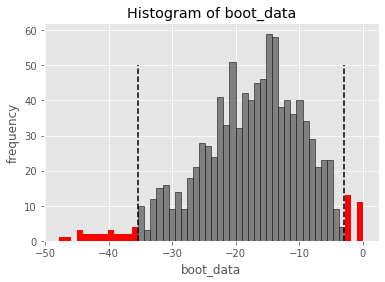

In [32]:
# данные с выбросами
booted_data_origin = get_bootstrap(df_origin[df_origin['experimentVariant'] == 'Control']['value'],\
             df_origin[df_origin['experimentVariant'] == 'Treatment']['value'])

In [34]:
pvalue_boot_origin = booted_data_origin["p_value"] # альфа
pvalue_boot_origin

0.03709257059727477

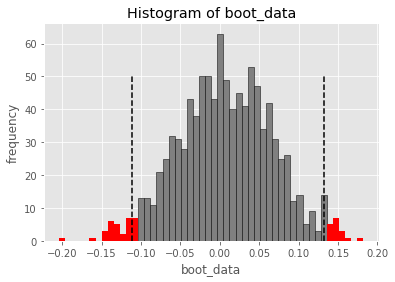

In [33]:
booted_data = get_bootstrap(df[df['experimentVariant'] == 'Control']['value'],\
             df[df['experimentVariant'] == 'Treatment']['value'])

In [35]:
pvalue_boot = booted_data["p_value"] # альфа
pvalue_boot

0.9086118389285914

Поскольку значения из выборки возвращаются назад, выбросы могли многокртно повторятся, что в конечном итоге сильно сместило значение средних.
Таким образом метод Бутсрапа в данном случае дал противоположные результаты о верности гипотез. 

Вывод: Для того, чтобы получать верные результаты тестирования необходимо прежде всего проверить данные, с которыми мы работаем. Если данные распределны норально, нет выбросов, и группы для сравнения всего две, то Т-тест отлично подходит. Если в данных все же пристуствуют выбросы, то лучше всего их нивелирует критерий Манна-Уитни. Бутсрап, известный, как наиболее простой метод, в даннмо случае также следует применять аккуратно, поскольку он среагировал сильно на экстремально высокие значения и не дал верного результата.

Также существуют специальные методы тестирования достверности используемых критериев.
Среди них - проведение А/А тестов, датасеты исторических данных компании, установка доверительных интервалов. 
Что касается выбросов - в данном случае их было легко и очевидно обнаружить, но чаще всего, они встречаются в более плавноп проявлении, и тогда, среди рекомендуемых мтодов обычно приводят:
-логорифмирование
- критерий Манна-Уитни
- убрать n% из топ

Изучив проблематику, я выяснла, что такие методы довольно часто дают ошибки в результатах, поскольку на разные сегменты пользователей тесты могут влиять по разному, и применение этих критериев хоть и даст нужный уровень P-значимости, но не даст возможности посомтреть на результаты внутри групп, которые могут взаимно перетягивать результат в нужную сторону за счет большой разницы.

Если нужно избавится от выбросов, лучше всего удалить топ пользователей на предэкспериментальном периоде. Но при этом надо помнить, что в таком случае топ пользователей может ввести себя не так, как остальные, и из-за этого вы можете принять неверное решение. Поэтому стоит дополнительно валидировать это предположение на старых A/B-тестах.